In [1]:
import zipfile
from glob import glob
import os
from netCDF4 import Dataset
import pandas as pd
import geopandas as gpd # GeoPandas(지오판다스)
from shapely.geometry import Polygon, LineString, Point
path = os.getcwd()

import rasterio
from rasterio.plot import show
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

import numpy as np

import requests
import time

from geocube.api.core import make_geocube
import seaborn as sns

* 기상자료 메타데이터

In [2]:
em_meta = pd.read_csv(glob(os.path.join(path,"시간단위_기상자료개방포털","rawdata","meta","*.csv",))[0],encoding='cp949')
geo_point = []
for i in range(len(em_meta)):
    x,y = em_meta.loc[i,'경도'], em_meta.loc[i,'위도']
    geo_point.append(Point(x,y))
    

em_meta['geometry'] = geo_point

em_point_gdf = gpd.GeoDataFrame(em_meta, geometry= 'geometry')
em_point_gdf.crs = {'init':'epsg:4326'}

em_point_gdf.head()

c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,지점,시작일,종료일,지점명,지점주소,관리관서,위도,경도,노장해발고도(m),기압계(관측장비지상높이(m)),기온계(관측장비지상높이(m)),풍속계(관측장비지상높이(m)),강우계(관측장비지상높이(m)),geometry
0,90,1968-01-01,NaN,속초,강원도 고성군토성면 봉포5길9 속초자동기상관측소,속초기상대(90),38.2509,128.5647,17.53,18.73,1.7,10.0,1.4,POINT (128.56470 38.25090)
1,93,2016-10-01,NaN,북춘천,강원도 춘천시신북읍 산천리264(장본1길 12) 춘천기상대,춘천기상대(101),37.9474,127.7544,95.78,96.78,1.5,10.0,1.4,POINT (127.75440 37.94740)
2,95,1988-01-01,NaN,철원,강원도 철원군갈말읍 명성로179번길 26 철원자동기상관측소,춘천기상대(101),38.1479,127.3042,155.48,156.98,1.8,13.0,1.5,POINT (127.30420 38.14790)
3,98,1998-02-01,NaN,동두천,경기도 동두천시방죽로 16-47동두천서비스센터,수도권기상청(119),37.9019,127.0607,115.62,116.74,1.7,10.0,1.0,POINT (127.06070 37.90190)
4,99,2013-10-22,NaN,파주,경기도 파주시문산읍 마정로46-29(파주기상대),수도권기상청(119),37.8859,126.7665,30.59,31.99,1.7,10.0,1.0,POINT (126.76650 37.88590)


* 먼지측정망 메타데이터

In [3]:
url = 'http://apis.data.go.kr/B552584/MsrstnInfoInqireSvc/getMsrstnList'
key = "k5wXUhoJHwee1cncQCBmm81YbQ+exttb0vdJcyF5GuGJn0mbGBNNL/ER2VfkrJMlExfc+FZjPeRuOM2bvgDYyQ=="

# params ={'serviceKey' : key, 'addr': '서울', 'stationName': '종로구', 'pageNo': 1, 'numOfRows': 10,'returnType': 'json'}
params ={'serviceKey' : key, 'pageNo': 1, 'numOfRows': 640,'returnType': 'json'}
response = requests.get(url, params=params, verify=False)

data_dic = response.json()
site_info = pd.DataFrame(data_dic['response']['body']['items'])

point_list = []
for i in range(len(site_info)):
    try:
        point_list.append(Point(float(site_info.dmY[i]), float(site_info.dmX[i])))
    except:
        point_list.append(None)

site_info.loc[:,'geometry'] = point_list
site_info_dropna = site_info.loc[~site_info.isna().dmX.values]

site_info_dropna = gpd.GeoDataFrame(site_info_dropna, geometry = 'geometry')
site_info_dropna.crs = em_point_gdf.crs

site_info_dropna.head()

c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,dmX,item,mangName,year,addr,stationName,dmY,geometry
0,36.644697,"SO2, CO, O3, NO2, PM10, PM2.5",도시대기,1989,충북 청주시 흥덕구 직지대로 393(송정동) 충북문화재연구원 옥상,송정동(봉명동),127.436808,POINT (127.43681 36.64470)
1,36.66608,"SO2, CO, O3, NO2, PM10, PM2.5",도시대기,1994,"충북 청주시 청원구 사천동 233-223번지(사뜸로 61번길 88-14), 청주청원...",사천동,127.474924,POINT (127.47492 36.66608)
2,36.635997,"SO2, CO, O3, NO2, PM10, PM2.5",도시대기,2002,충북 청주시 상당구 교동로139번길 20 라일락소공원 지상 (용담동),용담동,127.504028,POINT (127.50403 36.63600)
3,36.608818,"SO2, CO, O3, NO2, PM10, PM2.5",도시대기,2004,"충북 청주시 상당구 용암동 1590(중흥로 29), 용암1동 주민센터 3층 옥상 용...",용암동,127.501293,POINT (127.50129 36.60882)
4,36.634423,"SO2, CO, O3, NO2, PM10, PM2.5",도로변대기,2007,충북 청주시 흥덕구 복대동 111 산단육거리 교차점광장,복대동,127.447045,POINT (127.44705 36.63442)


* 배출량, 농도자료 경로

In [4]:
emis_list = glob(os.path.join('d:\Emission',"RSM_2_Apr_Jul","RSM_2","*"))
concentration_list = glob(os.path.join('d:\Concentration',"RSM_2_ACONC","RSM_2","*"))

In [61]:
import datetime

emis_day_list = [os.path.split(path)[-1].split('.')[-5] for path in emis_list]
concentration_day_list = [os.path.split(path)[-1].split('.')[-2] for path in concentration_list]


concentration_day_list_datetime = []
for date in concentration_day_list:

    start_date = datetime.date(int(date[:4]), 1, 1) + datetime.timedelta(-1)
    d_day = int(date[4:])
    target_date = start_date + datetime.timedelta(d_day)

    concentration_day_list_datetime.append(target_date)

emis_day_list_datetime = []
for date in emis_day_list:
    target_date = datetime.date(int(date[:4]), int(date[4:6]), int(date[6:]))
    emis_day_list_datetime.append(target_date)

emis_info_df = pd.DataFrame()
emis_info_df.loc[:,['date']] = emis_day_list_datetime
emis_info_df.loc[:,['path']] = emis_list

concentration_info_df = pd.DataFrame()
concentration_info_df.loc[:,['date']] = concentration_day_list_datetime
concentration_info_df.loc[:,['path']] = concentration_list
concentration_info_df = concentration_info_df.sort_values('date')
concentration_info_df.index = range(len(concentration_info_df))

con_emis_info_merged_df = pd.merge(concentration_info_df, emis_info_df, how='left', on='date', suffixes=['_concentration', '_emission'])
    

In [62]:
con_emis_info_merged_df

,date,path_concentration,path_emission
0,2012-12-22,d:\Concentration\RSM_2_ACONC\RSM_2\CCTM_GUIDE_...,NaN
1,2012-12-23,d:\Concentration\RSM_2_ACONC\RSM_2\CCTM_GUIDE_...,NaN
2,2012-12-24,d:\Concentration\RSM_2_ACONC\RSM_2\CCTM_GUIDE_...,NaN
3,2012-12-25,d:\Concentration\RSM_2_ACONC\RSM_2\CCTM_GUIDE_...,NaN
4,2012-12-26,d:\Concentration\RSM_2_ACONC\RSM_2\CCTM_GUIDE_...,NaN
...,...,...,...
158,2013-10-27,d:\Concentration\RSM_2_ACONC\RSM_2\CCTM_GUIDE_...,NaN
159,2013-10-28,d:\Concentration\RSM_2_ACONC\RSM_2\CCTM_GUIDE_...,NaN
160,2013-10-29,d:\Concentration\RSM_2_ACONC\RSM_2\CCTM_GUIDE_...,NaN
161,2013-10-30,d:\Concentration\RSM_2_ACONC\RSM_2\CCTM_GUIDE_...,NaN


In [64]:
con_emis_info_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 0 to 162
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                163 non-null    object
 1   path_concentration  163 non-null    object
 2   path_emission       81 non-null     object
dtypes: object(3)
memory usage: 5.1+ KB


* 배출량, 농도 일치하는 날짜인지 점검

In [76]:
con_emis_info_merged_df.loc[~con_emis_info_merged_df.path_emission.isna(),].iloc[0]

date                                                         2013-03-22
path_concentration    d:\Concentration\RSM_2_ACONC\RSM_2\CCTM_GUIDE_...
path_emission         d:\Emission\RSM_2_Apr_Jul\RSM_2\egts_l.2013032...
Name: 41, dtype: object

In [77]:
concen_data = Dataset(con_emis_info_merged_df.loc[~con_emis_info_merged_df.path_emission.isna(),].iloc[0].path_concentration, 'r')
emis_data = Dataset(con_emis_info_merged_df.loc[~con_emis_info_merged_df.path_emission.isna(),].iloc[0].path_emission, 'r')

In [78]:
concen_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    IOAPI_VERSION: ioapi-3.1: $Id:: init3.F 321 2016-02-26 16:00:20Z coats                $        
    EXEC_ID: ????????????????                                                                
    FTYPE: 1
    CDATE: 2019116
    CTIME: 91147
    WDATE: 2019116
    WTIME: 91147
    SDATE: 2013081
    STIME: 0
    TSTEP: 10000
    NTHIK: 1
    NCOLS: 67
    NROWS: 82
    NLAYS: 1
    NVARS: 153
    GDTYP: 2
    P_ALP: 30.0
    P_BET: 60.0
    P_GAM: 126.0
    XCENT: 126.0
    YCENT: 38.0
    XORIG: -180000.0
    YORIG: -585000.0
    XCELL: 9000.0
    YCELL: 9000.0
    VGTYP: 7
    VGTOP: 5000.0
    VGLVLS: [1. 0.]
    GDNAM: KNU_09_01       
    UPNAM: WR_ACONC        
    VAR-LIST: NO2             NO              O3P             O3              NO3             N2O5            HNO3            O1D2            HO              HONO            HO2             CO              HNO4            HO2H

In [79]:
emis_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    IOAPI_VERSION: ioapi-3.1: $Id:: init3.F 321 2016-02-26 16:00:20Z coats                $        
    EXEC_ID: ????????????????                                                                
    FTYPE: 1
    CDATE: 2019116
    CTIME: 91147
    WDATE: 2019116
    WTIME: 91147
    SDATE: 2013081
    STIME: 0
    TSTEP: 10000
    NTHIK: 1
    NCOLS: 67
    NROWS: 82
    NLAYS: 19
    NVARS: 45
    GDTYP: 2
    P_ALP: 30.0
    P_BET: 60.0
    P_GAM: 126.0
    XCENT: 126.0
    YCENT: 38.0
    XORIG: -180000.0
    YORIG: -585000.0
    XCELL: 9000.0
    YCELL: 9000.0
    VGTYP: 7
    VGTOP: 5000.0
    VGLVLS: [1.    0.996 0.99  0.98  0.97  0.96  0.95  0.94  0.93  0.91  0.89  0.87
 0.85  0.8   0.75  0.7   0.6   0.5   0.4   0.3  ]
    GDNAM: KNU_09_01       
    UPNAM: CTL_EMIS        
    VAR-LIST: NH3             ACET            ALK1            ALK2            ALK3            ALK4            AL

In [82]:
concen_data.variables['NO']

<class 'netCDF4._netCDF4.Variable'>
float32 NO(TSTEP, LAY, ROW, COL)
    long_name: NO              
    units: ppmV            
    var_desc: Variable NO                                                                     
unlimited dimensions: TSTEP
current shape = (24, 1, 82, 67)
filling on, default _FillValue of 9.969209968386869e+36 used

In [83]:
emis_data.variables['PSO4']

<class 'netCDF4._netCDF4.Variable'>
float32 PSO4(TSTEP, LAY, ROW, COL)
    long_name: PSO4            
    units: g/s             
    var_desc: Model species PSO4                                                              
unlimited dimensions: TSTEP
current shape = (25, 19, 82, 67)
filling on, default _FillValue of 9.969209968386869e+36 used

In [86]:
np.array(concen_data.variables['NO']).shape

(24, 1, 82, 67)

In [87]:
np.array(emis_data.variables['PSO4']).shape

(25, 19, 82, 67)

In [98]:
np.array(concen_data.variables['TFLAG'])

array([[[2013081,       0],
        [2013081,       0],
        [2013081,       0],
        ...,
        [2013081,       0],
        [2013081,       0],
        [2013081,       0]],

       [[2013081,   10000],
        [2013081,   10000],
        [2013081,   10000],
        ...,
        [2013081,   10000],
        [2013081,   10000],
        [2013081,   10000]],

       [[2013081,   20000],
        [2013081,   20000],
        [2013081,   20000],
        ...,
        [2013081,   20000],
        [2013081,   20000],
        [2013081,   20000]],

       ...,

       [[2013081,  210000],
        [2013081,  210000],
        [2013081,  210000],
        ...,
        [2013081,  210000],
        [2013081,  210000],
        [2013081,  210000]],

       [[2013081,  220000],
        [2013081,  220000],
        [2013081,  220000],
        ...,
        [2013081,  220000],
        [2013081,  220000],
        [2013081,  220000]],

       [[2013081,  230000],
        [2013081,  230000],
        [2013081

In [99]:
np.array(emis_data.variables['TFLAG'])

array([[[2013081,       0],
        [2013081,       0],
        [2013081,       0],
        ...,
        [2013081,       0],
        [2013081,       0],
        [2013081,       0]],

       [[2013081,   10000],
        [2013081,   10000],
        [2013081,   10000],
        ...,
        [2013081,   10000],
        [2013081,   10000],
        [2013081,   10000]],

       [[2013081,   20000],
        [2013081,   20000],
        [2013081,   20000],
        ...,
        [2013081,   20000],
        [2013081,   20000],
        [2013081,   20000]],

       ...,

       [[2013081,  220000],
        [2013081,  220000],
        [2013081,  220000],
        ...,
        [2013081,  220000],
        [2013081,  220000],
        [2013081,  220000]],

       [[2013081,  230000],
        [2013081,  230000],
        [2013081,  230000],
        ...,
        [2013081,  230000],
        [2013081,  230000],
        [2013081,  230000]],

       [[2013082,       0],
        [2013082,       0],
        [2013082

In [134]:
np.array(concen_data.variables['NO'])[0,:,:,:] # 0~23

array([[[2.6713513e-05, 2.4510808e-05, 2.5294232e-05, ...,
         7.7369550e-05, 7.7798410e-05, 7.9629179e-05],
        [2.8032451e-05, 2.6763346e-05, 2.8404242e-05, ...,
         6.0172795e-05, 5.9584112e-05, 5.9437680e-05],
        [2.9668447e-05, 2.9635090e-05, 2.9164908e-05, ...,
         5.8083140e-05, 5.7936602e-05, 5.8027650e-05],
        ...,
        [6.8863294e-05, 6.9291120e-05, 7.3358591e-05, ...,
         4.8348680e-05, 4.7945559e-05, 4.7597750e-05],
        [6.9913709e-05, 7.0278358e-05, 7.8510500e-05, ...,
         4.9839549e-05, 4.9191469e-05, 4.8610276e-05],
        [7.1282746e-05, 7.1365146e-05, 8.5111038e-05, ...,
         5.1355495e-05, 5.0369428e-05, 5.0687922e-05]]], dtype=float32)

In [97]:
np.array(emis_data.variables['PSO4'])[0,0,:,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

* 기상, 대기질측정망 일치하는 날짜 병합 점검

In [100]:
# 대기질자료 불러오기
airpolutant_monitoring_2013_list = glob(os.path.join(path,"시간단위대기질자료","rawdata","extract","2013*",))
airpolutant_monitoring_2013_list
data_list = []
for i in airpolutant_monitoring_2013_list:
    temp_data = pd.read_excel(i)
    data_list.append(temp_data)
air_pol_2013 = pd.concat(data_list)
air_pol_2013.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2766000 entries, 0 to 699935
Data columns (total 10 columns):
 #   Column  Dtype  
---  ------  -----  
 0   지역      object 
 1   측정소명    object 
 2   측정소코드   int64  
 3   측정일시    int64  
 4   SO2     float64
 5   CO      float64
 6   O3      float64
 7   NO2     float64
 8   PM10    int64  
 9   주소      object 
dtypes: float64(4), int64(3), object(3)
memory usage: 232.1+ MB


In [101]:
#기상자료 불러오기
em_dataset_path_list = glob(os.path.join(path,"시간단위_기상자료개방포털","rawdata","extract","*.csv",))
em_dataset_list = [pd.read_csv(path, encoding='cp949') for path in em_dataset_path_list]
em_df = pd.concat(em_dataset_list, axis = 0)
em_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262839 entries, 0 to 8794
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   지점             262839 non-null  int64  
 1   일시             262839 non-null  object 
 2   기온(°C)         262609 non-null  float64
 3   강수량(mm)        19578 non-null   float64
 4   풍속(m/s)        262522 non-null  float64
 5   풍향(16방위)       262520 non-null  float64
 6   습도(%)          262609 non-null  float64
 7   증기압(hPa)       262610 non-null  float64
 8   이슬점온도(°C)      262608 non-null  float64
 9   현지기압(hPa)      262625 non-null  float64
 10  해면기압(hPa)      262608 non-null  float64
 11  일조(hr)         143715 non-null  float64
 12  일사(MJ/m2)      47839 non-null   float64
 13  적설(cm)         4110 non-null    float64
 14  3시간신적설(cm)     186 non-null     float64
 15  전운량(10분위)      20597 non-null   float64
 16  중하층운량(10분위)    20597 non-null   float64
 17  운형(운형약어)       14637 non-null  

In [130]:
datetime_airpol = [datetime.datetime(int(date[:4]),int(date[4:6]),int(date[6:8]),int(date[8:] if date[8:] !='24' else '0')) for date in air_pol_2013.측정일시.values.astype(str)]
air_pol_2013.loc[:,'datetime'] = datetime_airpol
em_df.loc[:,'datetime'] = pd.to_datetime(em_df.일시)

In [131]:
air_pol_2013

,지역,측정소명,측정소코드,측정일시,SO2,CO,O3,NO2,PM10,주소,datetime
0,서울,중구,111121,2013010101,0.0060,1.1,0.003,0.0610,30,서울 중구 서소문동,2013-01-01 01:00:00
1,서울,중구,111121,2013010102,0.0060,1.1,0.003,0.0580,42,서울 중구 서소문동,2013-01-01 02:00:00
2,서울,중구,111121,2013010103,0.0060,0.9,0.003,0.0510,46,서울 중구 서소문동,2013-01-01 03:00:00
3,서울,중구,111121,2013010104,0.0060,0.9,0.004,0.0460,30,서울 중구 서소문동,2013-01-01 04:00:00
4,서울,중구,111121,2013010105,0.0050,0.8,0.005,0.0390,25,서울 중구 서소문동,2013-01-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...
699931,인천 옹진군,백령도,831492,2013123120,0.0085,0.6,0.023,0.0110,209,인천 옹진군 백령면 연화리,2013-12-31 20:00:00
699932,인천 옹진군,백령도,831492,2013123121,0.0086,0.8,0.023,0.0107,189,인천 옹진군 백령면 연화리,2013-12-31 21:00:00
699933,인천 옹진군,백령도,831492,2013123122,0.0048,0.3,0.032,0.0037,172,인천 옹진군 백령면 연화리,2013-12-31 22:00:00
699934,인천 옹진군,백령도,831492,2013123123,0.0042,0.2,0.032,0.0023,127,인천 옹진군 백령면 연화리,2013-12-31 23:00:00


In [132]:
em_df

,지점,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),...,최저운고(100m ),시정(10m),지면상태(지면상태코드),현상번호(국내식),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C),datetime
0,254,2013-01-01 00:00,-5.5,NaN,0.4,0.0,92.0,3.8,-6.5,1006.1,...,NaN,NaN,NaN,NaN,-1.7,0.1,-0.7,0.5,0.7,2013-01-01 00:00:00
1,254,2013-01-01 01:00,-5.7,NaN,0.0,0.0,92.0,3.7,-6.7,1005.9,...,NaN,NaN,NaN,NaN,-1.4,0.1,-0.7,0.5,0.7,2013-01-01 01:00:00
2,254,2013-01-01 02:00,-5.5,NaN,0.7,140.0,92.0,3.8,-6.5,1005.9,...,NaN,NaN,NaN,NaN,-1.5,0.1,-0.7,0.5,0.6,2013-01-01 02:00:00
3,254,2013-01-01 03:00,-5.5,NaN,0.7,70.0,92.0,3.8,-6.5,1005.9,...,NaN,NaN,NaN,NaN,-1.5,0.1,-0.7,0.5,0.7,2013-01-01 03:00:00
4,254,2013-01-01 04:00,-5.2,NaN,0.3,0.0,94.0,3.9,-6.0,1005.0,...,NaN,NaN,NaN,NaN,-1.5,0.2,-0.7,0.5,0.7,2013-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8790,99,2013-12-31 19:00,3.5,NaN,2.5,200.0,71.0,5.6,-1.2,1005.1,...,NaN,NaN,NaN,NaN,0.3,NaN,NaN,NaN,NaN,2013-12-31 19:00:00
8791,99,2013-12-31 20:00,4.4,NaN,3.3,230.0,67.0,5.6,-1.2,1005.8,...,NaN,NaN,NaN,NaN,0.3,NaN,NaN,NaN,NaN,2013-12-31 20:00:00
8792,99,2013-12-31 21:00,4.4,NaN,2.7,270.0,59.0,4.9,-2.9,1006.5,...,NaN,NaN,NaN,NaN,0.3,NaN,NaN,NaN,NaN,2013-12-31 21:00:00
8793,99,2013-12-31 22:00,3.5,NaN,1.9,250.0,62.0,4.9,-3.1,1007.3,...,NaN,NaN,NaN,NaN,0.2,NaN,NaN,NaN,NaN,2013-12-31 22:00:00


### 데이터셋 구성 예시

In [141]:
con_emis_info_merged_df_dropna = con_emis_info_merged_df.loc[~con_emis_info_merged_df.path_emission.isna(),]
con_emis_info_merged_df_dropna.index = range(len(con_emis_info_merged_df_dropna))

In [177]:
i = 0
today = con_emis_info_merged_df_dropna.loc[i].date
print(today)

concen_data = Dataset(con_emis_info_merged_df_dropna.loc[i].path_concentration, 'r')
emis_data = Dataset(con_emis_info_merged_df_dropna.loc[i].path_emission, 'r')

day_concen_o3 = np.array(concen_data.variables['O3'])
day_emis_pso4 = np.array(emis_data.variables['PSO4'])


hour_ind = 1 # 실제할때는 24시간 루프돌리면됨
datetime_ind = datetime.datetime(today.year, today.month, today.day, hour_ind)



2013-03-22


In [229]:
em_df.loc[em_df.datetime == datetime_ind].head()

,지점,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),...,최저운고(100m ),시정(10m),지면상태(지면상태코드),현상번호(국내식),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C),datetime
1921,254,2013-03-22 01:00,-0.2,NaN,1.6,270.0,80.0,4.8,-3.2,999.3,...,NaN,NaN,NaN,NaN,-0.3,4.5,5.0,7.4,7.5,2013-03-22 01:00:00
1921,255,2013-03-22 01:00,4.1,NaN,0.2,0.0,47.0,3.8,-6.2,1007.8,...,NaN,NaN,NaN,NaN,2.3,8.8,9.5,9.9,9.7,2013-03-22 01:00:00
1921,257,2013-03-22 01:00,4.1,NaN,2.3,200.0,60.0,4.9,-2.9,1013.0,...,NaN,NaN,NaN,NaN,3.4,8.0,9.0,10.9,11.3,2013-03-22 01:00:00
1921,258,2013-03-22 01:00,1.1,NaN,1.8,290.0,88.0,5.8,-0.6,1014.8,...,NaN,NaN,NaN,NaN,2.0,6.2,6.8,8.9,9.2,2013-03-22 01:00:00
1921,259,2013-03-22 01:00,-0.1,NaN,1.6,320.0,82.0,5.0,-2.8,1013.9,...,NaN,NaN,NaN,NaN,2.7,5.8,7.2,8.2,8.7,2013-03-22 01:00:00


In [230]:
air_pol_2013.loc[air_pol_2013.datetime == datetime_ind].head()

,지역,측정소명,측정소코드,측정일시,SO2,CO,O3,NO2,PM10,주소,datetime
1920,서울,중구,111121,2013032201,0.010,0.3,0.002,0.059,35,서울 중구 서소문동,2013-03-22 01:00:00
4080,서울,한강대로,111122,2013032201,0.012,0.9,0.003,0.061,44,서울 용산구 동자동,2013-03-22 01:00:00
6240,서울,종로구,111123,2013032201,0.011,0.6,0.007,0.066,35,서울 종로구 효제동,2013-03-22 01:00:00
8400,서울,청계천,111124,2013032201,0.010,0.8,0.002,0.075,42,서울 중구 주교동,2013-03-22 01:00:00
10560,서울,종로,111125,2013032201,0.009,0.5,0.002,0.063,36,서울 종로구 종로4가,2013-03-22 01:00:00


68 83


c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


(82, 67) -180000.0 153000.0 423000.0 -585000.0


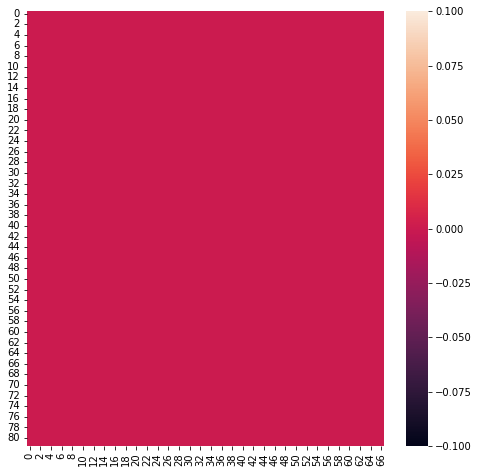

In [203]:
# lcc프로젝션 기본 레스터 제작
projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

# out_grid = make_geocube(vector_data=test_data, measurements=["습도(%)"], geom=geom,resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
x_m = list(range(-180000,-180000 + 9000 * 68, 9000))
y_m = list(range(-585000,-585000 + 9000 * 83, 9000))

print(len(x_m), len(y_m))

grid_points = []
for x_i in x_m:
    for y_i in y_m:
        grid_points.append(Point(x_i,y_i))

grid_data = pd.DataFrame(grid_points, columns=['geometry'])

grid_data = gpd.GeoDataFrame(grid_data, geometry='geometry')
grid_data.crs = em_point_gdf.to_crs(projout).crs
grid_data.loc[:,'x_m'] = grid_data.geometry.x
grid_data.loc[:,'y_m'] = grid_data.geometry.y
grid_data.loc[:,'value'] = 0

out_grid = make_geocube(vector_data=grid_data, measurements=["value"],resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
out_grid["value"].rio.to_raster("base_lcc.tif")
# 레스터 좌표변환
# 5181로 변환하면 좌표들 약간 틀어짐
# lcc로 처리 해야함
from rasterio.warp import calculate_default_transform, reproject, Resampling
# dst_crs = 'epsg: 5181'
dst_crs = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

with rasterio.open(os.path.join(path,"base_lcc.tif")) as src:

    transform, width, height = calculate_default_transform(
                    src.crs, 
                    dst_crs, 
                    src.width, 
                    src.height, 
                    *src.bounds)
   
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(os.path.join(path,"base_lcc_lcc.tif"), 'w', **kwargs) as dst:
            
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [205]:
air_pol_datetime_ind_df = air_pol_2013.loc[air_pol_2013.datetime == datetime_ind]
air_pol_datetime_ind_df.index = range(len(air_pol_datetime_ind_df))

air_pol_datetime_ind_df_geoinfo = pd.merge(air_pol_datetime_ind_df,site_info_dropna.loc[:,['stationName', 'geometry']],how='left',left_on='측정소명',right_on='stationName')
air_pol_datetime_ind_df_geoinfo = air_pol_datetime_ind_df_geoinfo.loc[~air_pol_datetime_ind_df_geoinfo.stationName.isna()]
air_pol_datetime_ind_df_geoinfo.index = range(len(air_pol_datetime_ind_df_geoinfo))
air_pol_datetime_ind_df_geoinfo = gpd.GeoDataFrame(air_pol_datetime_ind_df_geoinfo, geometry='geometry')

# 측정망자료 레스터화
projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

# out_grid = make_geocube(vector_data=test_data, measurements=["습도(%)"], geom=geom,resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
out_grid = make_geocube(vector_data=air_pol_datetime_ind_df_geoinfo, measurements=["PM10"],resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
out_grid["PM10"].rio.to_raster("rasterized_air_pol.tif")


dst_crs = projout
with rasterio.open(os.path.join(path,"rasterized_air_pol.tif")) as src:
    print(src.width, src.height, *src.bounds,)
    transform, width, height = calculate_default_transform(
                    src.crs, 
                    dst_crs, 
                    src.width, 
                    src.height, 
                    *src.bounds)
   
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(os.path.join(path,"rasterized_air_pol_lcc.tif"), 'w', **kwargs) as dst:
            
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)


59 62 -117000.0 36000.0 414000.0 -522000.0


(82, 67)


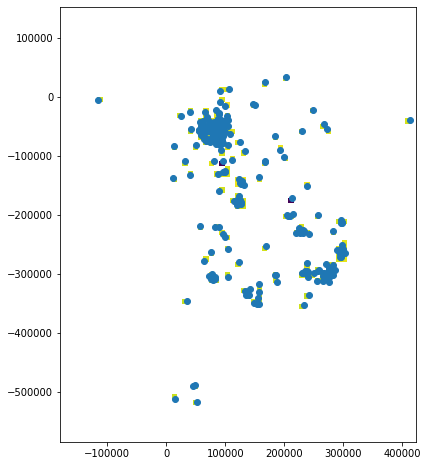

In [210]:
from rasterio.merge import merge

with rasterio.open(os.path.join(path,"base_lcc_lcc.tif")) as src, rasterio.open(os.path.join(path,"rasterized_air_pol_lcc.tif")) as src2:
    raster_list = [src, src2]
    # print(src.read(1).shape, src2.read(1).shape,)
    mosaic, output = merge(raster_list)

    output_meta = src2.meta.copy()
    output_meta.update(
        {"driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": output,
        }
    )

    with rasterio.open(os.path.join(path,"rasterized_air_pol_lcc_final.tif"), "w", **output_meta) as m:
        m.write(mosaic)


with rasterio.open(os.path.join(path,"rasterized_air_pol_lcc_final.tif")) as src:
    fig, ax = plt.subplots(figsize=(8, 8))
    
    show(src, ax=ax)
    air_pol_datetime_ind_df_geoinfo.to_crs(dst_crs).plot(ax=ax)

    # site_info_dropna.plot(ax=ax,color = 'yellow')

    print(src.read(1).shape)

In [226]:
em_df_ind_df = em_df.loc[em_df.datetime == datetime_ind]
em_df_ind_df.index = range(len(em_df_ind_df))
em_df_ind_df_geoinfo = pd.merge(em_df_ind_df,em_point_gdf.loc[:,['지점', 'geometry']],how='left',on = '지점')

em_df_ind_df_geoinfo = em_df_ind_df_geoinfo.loc[~em_df_ind_df_geoinfo.geometry.isna()]
em_df_ind_df_geoinfo.index = range(len(em_df_ind_df_geoinfo))
em_df_ind_df_geoinfo = gpd.GeoDataFrame(em_df_ind_df_geoinfo, geometry='geometry')


# 측정망자료 레스터화
projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

# out_grid = make_geocube(vector_data=test_data, measurements=["습도(%)"], geom=geom,resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
out_grid = make_geocube(vector_data=em_df_ind_df_geoinfo, measurements=["풍향(16방위)"],resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
out_grid["풍향(16방위)"].rio.to_raster("rasterized_em.tif")


dst_crs = projout
with rasterio.open(os.path.join(path,"rasterized_em.tif")) as src:
    print(src.width, src.height, *src.bounds,)
    transform, width, height = calculate_default_transform(
                    src.crs, 
                    dst_crs, 
                    src.width, 
                    src.height, 
                    *src.bounds)
   
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(os.path.join(path,"rasterized_em_lcc.tif"), 'w', **kwargs) as dst:
            
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

29 46 45000.0 36000.0 306000.0 -378000.0


(82, 67)


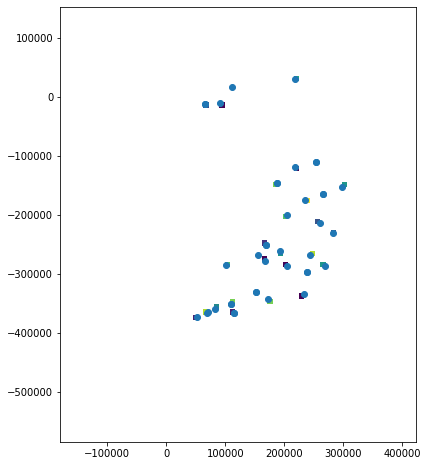

In [228]:
from rasterio.merge import merge

with rasterio.open(os.path.join(path,"base_lcc_lcc.tif")) as src, rasterio.open(os.path.join(path,"rasterized_em_lcc.tif")) as src2:
    raster_list = [src, src2]
    # print(src.read(1).shape, src2.read(1).shape,)
    mosaic, output = merge(raster_list)

    output_meta = src2.meta.copy()
    output_meta.update(
        {"driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": output,
        }
    )

    with rasterio.open(os.path.join(path,"rasterized_em_lcc_final.tif"), "w", **output_meta) as m:
        m.write(mosaic)


with rasterio.open(os.path.join(path,"rasterized_em_lcc_final.tif")) as src:
    fig, ax = plt.subplots(figsize=(8, 8))
    
    show(src, ax=ax)
    em_df_ind_df_geoinfo.to_crs(dst_crs).plot(ax=ax)

    # site_info_dropna.plot(ax=ax,color = 'yellow')

    print(src.read(1).shape)

In [ ]:
# day_concen_o3
# day_emis_pso4

<AxesSubplot: >

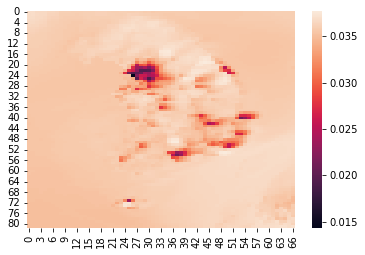

In [235]:
sns.heatmap(day_concen_o3[hour_ind,0,:,:][::-1])

<AxesSubplot: >

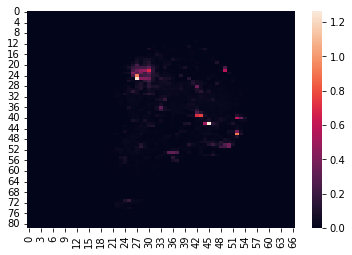

In [236]:
sns.heatmap(day_emis_pso4[hour_ind,0,:,:][::-1])

(82, 67) (82, 67) (82, 67) (82, 67)


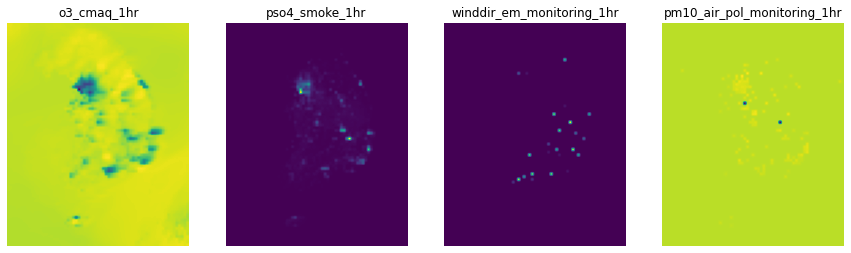

In [241]:
plt.figure(figsize=(15, 15))

with rasterio.open(os.path.join(path,"rasterized_em_lcc_final.tif")) as src1, rasterio.open(os.path.join(path,"rasterized_air_pol_lcc_final.tif")) as src2:


    concent_1hr_o3 = day_concen_o3[hour_ind,0,:,:][::-1]
    emis_1hr_pso4 = day_emis_pso4[hour_ind,0,:,:][::-1]

    em_monitor_1hr_winddir = src1.read(1)
    air_pol_monitor_1hr_pm10 = src2.read(1)
      
    print(concent_1hr_o3.shape, emis_1hr_pso4.shape, em_monitor_1hr_winddir.shape, air_pol_monitor_1hr_pm10.shape,)
    
    display_list = [concent_1hr_o3, emis_1hr_pso4, em_monitor_1hr_winddir, air_pol_monitor_1hr_pm10]
    title = ['o3_cmaq_1hr', 'pso4_smoke_1hr', 'winddir_em_monitoring_1hr', 'pm10_air_pol_monitoring_1hr']

    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        # plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

### 데이터셋 생성
* 시나리오2
* 1시간단위 4,7월데이터
* CMAQ_PM10, SMOKE_전체, PM10모니터링, 기상모니터링
* pm10 =>
(1.0*ASO4J[1])+(1.0*ASO4I[1])+(1.0*ANH4J[1])+(1.0*ANH4I[1])+(1.0*ANO3J[1])+(1.0*ANO3I[1])+(1.0*AALKJ[1])+(1.0*AXYL1J[1])+(1.0*AXYL2J[1])+(1.0*AXYL3J[1])+(1.0*ATOL1J[1])+(1.0*ATOL2J[1])+(1.0*ATOL3J[1])+(1.0*ABNZ1J[1])+(1.0*ABNZ2J[1])+(1.0*ABNZ3J[1])+(1.0*ATRP1J[1])+(1.0*ATRP2J[1])+(1.0*AISO1J[1])+(1.0*AISO2J[1])+(1.0*AISO3J[1])+(1.0*ASQTJ[1])+(1.0*AORGCJ[1])+(1.0*AORGPAJ[1])+(1.0*AORGPAI[1])\
+(1.0*AECJ[1])+(1.0*AECI[1])+(1.0*A25J[1])+(1.0*ANAJ[1])+(1.0*ACLJ[1])+(1.0*ACLI[1])+(1.0*AOLGAJ[1])+(1.0*AOLGBJ[1])+(1.0*ACORS[1])+(1.0*ASOIL[1])+(1.0*ANAK[1])+(1.0*ACLK[1])+(1.0*ASO4K[1])+(1.0*ANH4K[1])+(1.0*ANO3K[1])

In [1]:
import zipfile
from glob import glob
import os
from netCDF4 import Dataset
import pandas as pd
import geopandas as gpd # GeoPandas(지오판다스)
from shapely.geometry import Polygon, LineString, Point
path = os.getcwd()

import rasterio
from rasterio.plot import show
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

import numpy as np

import requests
import time

from geocube.api.core import make_geocube
import seaborn as sns

from rasterio.merge import merge

* 기본자료 준비

In [3]:
# 기상측정망, 대기질측정망 메타정보 정리
em_meta = pd.read_csv(glob(os.path.join(path,"시간단위_기상자료개방포털","rawdata","meta","*.csv",))[0],encoding='cp949')
geo_point = []
for i in range(len(em_meta)):
    x,y = em_meta.loc[i,'경도'], em_meta.loc[i,'위도']
    geo_point.append(Point(x,y))
    

em_meta['geometry'] = geo_point

em_point_gdf = gpd.GeoDataFrame(em_meta, geometry= 'geometry')
em_point_gdf.crs = {'init':'epsg:4326'}

url = 'http://apis.data.go.kr/B552584/MsrstnInfoInqireSvc/getMsrstnList'
key = "k5wXUhoJHwee1cncQCBmm81YbQ+exttb0vdJcyF5GuGJn0mbGBNNL/ER2VfkrJMlExfc+FZjPeRuOM2bvgDYyQ=="

# params ={'serviceKey' : key, 'addr': '서울', 'stationName': '종로구', 'pageNo': 1, 'numOfRows': 10,'returnType': 'json'}
params ={'serviceKey' : key, 'pageNo': 1, 'numOfRows': 640,'returnType': 'json'}
response = requests.get(url, params=params, verify=False)

data_dic = response.json()
site_info = pd.DataFrame(data_dic['response']['body']['items'])

point_list = []
for i in range(len(site_info)):
    try:
        point_list.append(Point(float(site_info.dmY[i]), float(site_info.dmX[i])))
    except:
        point_list.append(None)

site_info.loc[:,'geometry'] = point_list
site_info_dropna = site_info.loc[~site_info.isna().dmX.values]

site_info_dropna = gpd.GeoDataFrame(site_info_dropna, geometry = 'geometry')
site_info_dropna.crs = em_point_gdf.crs

c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [8]:
# 대기질자료 불러오기
airpolutant_monitoring_2013_list = glob(os.path.join(path,"시간단위대기질자료","rawdata","extract","2013*",))
airpolutant_monitoring_2013_list
data_list = []
for i in airpolutant_monitoring_2013_list:
    temp_data = pd.read_excel(i)
    data_list.append(temp_data)
air_pol_2013 = pd.concat(data_list)
air_pol_2013.info()

#기상자료 불러오기
em_dataset_path_list = glob(os.path.join(path,"시간단위_기상자료개방포털","rawdata","extract","*.csv",))
em_dataset_list = [pd.read_csv(path, encoding='cp949') for path in em_dataset_path_list]
em_df = pd.concat(em_dataset_list, axis = 0)
em_df.info()
datetime_airpol = [datetime.datetime(int(date[:4]),int(date[4:6]),int(date[6:8]),int(date[8:] if date[8:] !='24' else '0')) for date in air_pol_2013.측정일시.values.astype(str)]
air_pol_2013.loc[:,'datetime'] = datetime_airpol
em_df.loc[:,'datetime'] = pd.to_datetime(em_df.일시)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2766000 entries, 0 to 699935
Data columns (total 10 columns):
 #   Column  Dtype  
---  ------  -----  
 0   지역      object 
 1   측정소명    object 
 2   측정소코드   int64  
 3   측정일시    int64  
 4   SO2     float64
 5   CO      float64
 6   O3      float64
 7   NO2     float64
 8   PM10    int64  
 9   주소      object 
dtypes: float64(4), int64(3), object(3)
memory usage: 232.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 262839 entries, 0 to 8794
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   지점             262839 non-null  int64  
 1   일시             262839 non-null  object 
 2   기온(°C)         262609 non-null  float64
 3   강수량(mm)        19578 non-null   float64
 4   풍속(m/s)        262522 non-null  float64
 5   풍향(16방위)       262520 non-null  float64
 6   습도(%)          262609 non-null  float64
 7   증기압(hPa)       262610 non-null  float64
 8   이슬점온도(°C

In [9]:
# lcc프로젝션 기본 레스터 제작
projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

# out_grid = make_geocube(vector_data=test_data, measurements=["습도(%)"], geom=geom,resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
x_m = list(range(-180000,-180000 + 9000 * 68, 9000))
y_m = list(range(-585000,-585000 + 9000 * 83, 9000))

print(len(x_m), len(y_m))

grid_points = []
for x_i in x_m:
    for y_i in y_m:
        grid_points.append(Point(x_i,y_i))

grid_data = pd.DataFrame(grid_points, columns=['geometry'])

grid_data = gpd.GeoDataFrame(grid_data, geometry='geometry')
grid_data.crs = em_point_gdf.to_crs(projout).crs
grid_data.loc[:,'x_m'] = grid_data.geometry.x
grid_data.loc[:,'y_m'] = grid_data.geometry.y
grid_data.loc[:,'value'] = 0

out_grid = make_geocube(vector_data=grid_data, measurements=["value"],resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
out_grid["value"].rio.to_raster("base_lcc.tif")
# 레스터 좌표변환
# 5181로 변환하면 좌표들 약간 틀어짐
# lcc로 처리 해야함
from rasterio.warp import calculate_default_transform, reproject, Resampling
# dst_crs = 'epsg: 5181'
dst_crs = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

with rasterio.open(os.path.join(path,"base_lcc.tif")) as src:

    transform, width, height = calculate_default_transform(
                    src.crs, 
                    dst_crs, 
                    src.width, 
                    src.height, 
                    *src.bounds)
   
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(os.path.join(path,"base_lcc_lcc.tif"), 'w', **kwargs) as dst:
            
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

68 83


c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [10]:
# pm10 합산해서 계산하는 수식 및 chem 리스트
pm_10_cal = "(1.0*ASO4J[1])+(1.0*ASO4I[1])+(1.0*ANH4J[1])+(1.0*ANH4I[1])+(1.0*ANO3J[1])+(1.0*ANO3I[1])+(1.0*AALKJ[1])+(1.0*AXYL1J[1])+(1.0*AXYL2J[1])+(1.0*AXYL3J[1])+(1.0*ATOL1J[1])+(1.0*ATOL2J[1])+(1.0*ATOL3J[1])+(1.0*ABNZ1J[1])+(1.0*ABNZ2J[1])+(1.0*ABNZ3J[1])+(1.0*ATRP1J[1])+(1.0*ATRP2J[1])+(1.0*AISO1J[1])+(1.0*AISO2J[1])+(1.0*AISO3J[1])+(1.0*ASQTJ[1])+(1.0*AORGCJ[1])+(1.0*AORGPAJ[1])+(1.0*AORGPAI[1])+(1.0*AECJ[1])+(1.0*AECI[1])+(1.0*A25J[1])+(1.0*ANAJ[1])+(1.0*ACLJ[1])+(1.0*ACLI[1])+(1.0*AOLGAJ[1])+(1.0*AOLGBJ[1])+(1.0*ACORS[1])+(1.0*ASOIL[1])+(1.0*ANAK[1])+(1.0*ACLK[1])+(1.0*ASO4K[1])+(1.0*ANH4K[1])+(1.0*ANO3K[1])"
pm_10_chem_list = [chem[5:-4] for chem in pm_10_cal.split("+")]

In [11]:
# 날짜별 smoke, cmaq데이터셋 경로 정리
emis_list = glob(os.path.join('d:\Emission',"RSM_2_Apr_Jul","RSM_2","*"))
concentration_list = glob(os.path.join('d:\Concentration',"RSM_2_ACONC","RSM_2","*"))
import datetime

emis_day_list = [os.path.split(path)[-1].split('.')[-5] for path in emis_list]
concentration_day_list = [os.path.split(path)[-1].split('.')[-2] for path in concentration_list]


concentration_day_list_datetime = []
for date in concentration_day_list:

    start_date = datetime.date(int(date[:4]), 1, 1) + datetime.timedelta(-1)
    d_day = int(date[4:])
    target_date = start_date + datetime.timedelta(d_day)

    concentration_day_list_datetime.append(target_date)

emis_day_list_datetime = []
for date in emis_day_list:
    target_date = datetime.date(int(date[:4]), int(date[4:6]), int(date[6:]))
    emis_day_list_datetime.append(target_date)

emis_info_df = pd.DataFrame()
emis_info_df.loc[:,['date']] = emis_day_list_datetime
emis_info_df.loc[:,['path']] = emis_list

concentration_info_df = pd.DataFrame()
concentration_info_df.loc[:,['date']] = concentration_day_list_datetime
concentration_info_df.loc[:,['path']] = concentration_list
concentration_info_df = concentration_info_df.sort_values('date')
concentration_info_df.index = range(len(concentration_info_df))

con_emis_info_merged_df = pd.merge(concentration_info_df, emis_info_df, how='left', on='date', suffixes=['_concentration', '_emission'])
    
con_emis_info_merged_df_dropna = con_emis_info_merged_df.loc[~con_emis_info_merged_df.path_emission.isna(),]
con_emis_info_merged_df_dropna.index = range(len(con_emis_info_merged_df_dropna))

In [59]:
# hour_ind = 1 # 실제할때는 24시간 루프돌리면됨
# datetime_ind = datetime.datetime(today.year, today.month, today.day, hour_ind)

i = 0
today = con_emis_info_merged_df_dropna.loc[i].date
print(today)
# 해당날짜의 데이터셋 불러오기
concen_data = Dataset(con_emis_info_merged_df_dropna.loc[i].path_concentration, 'r')
emis_data = Dataset(con_emis_info_merged_df_dropna.loc[i].path_emission, 'r')

# 해당날짜의 관련변수 합으로 pm10 CMAQ array형성
pm10_chemlist = [np.array(concen_data.variables[chem]) for chem in pm_10_chem_list]
day_concen_pm10 = np.sum(pm10_chemlist, axis=0)
day_concen_pm10 = day_concen_pm10.reshape(day_concen_pm10.shape[0],day_concen_pm10.shape[2],day_concen_pm10.shape[3],-1)

# 해당날짜의 smoke 모든변수 array 형성, 연직방향으로는 맨 밑레이어만 사용
smoke_chem_list = list(set(emis_data.variables.keys()) - set(['TFLAG']))
smoke_chem_arr_list = [np.array(emis_data.variables[chem])[:,0:1,:,:].reshape(25,82,67,-1) for chem in smoke_chem_list]
day_smoke_allval = np.concatenate(smoke_chem_arr_list, axis=3)
day_smoke_allval = day_smoke_allval[:24]

print('CMAQ_PM10 데이터셋: ',day_concen_pm10.shape, 'SMOKE_모든변수 데이터셋: ',day_smoke_allval.shape)


2013-03-22
CMAQ_PM10 데이터셋:  (24, 82, 67, 1) SMOKE_모든변수 데이터셋:  (24, 82, 67, 45)


In [137]:
hour_ind = 1 
datetime_ind = datetime.datetime(today.year, today.month, today.day, hour_ind)

In [143]:
air_pol_datetime_ind_df = air_pol_2013.loc[air_pol_2013.datetime == datetime_ind]
air_pol_datetime_ind_df.index = range(len(air_pol_datetime_ind_df))

air_pol_datetime_ind_df_geoinfo = pd.merge(air_pol_datetime_ind_df,site_info_dropna.loc[:,['stationName', 'geometry']],how='left',left_on='측정소명',right_on='stationName')
air_pol_datetime_ind_df_geoinfo = air_pol_datetime_ind_df_geoinfo.loc[~air_pol_datetime_ind_df_geoinfo.stationName.isna()]
air_pol_datetime_ind_df_geoinfo.index = range(len(air_pol_datetime_ind_df_geoinfo))
air_pol_datetime_ind_df_geoinfo = gpd.GeoDataFrame(air_pol_datetime_ind_df_geoinfo, geometry='geometry')
air_pol_datetime_ind_df_geoinfo = air_pol_datetime_ind_df_geoinfo.fillna(0)
air_pol_datetime_ind_df_geoinfo = air_pol_datetime_ind_df_geoinfo.loc[~(air_pol_datetime_ind_df_geoinfo.PM10 == -999)]  # 값이 -999찍혀있을때가 있음 기기오작동으로보고 제거
air_pol_datetime_ind_df_geoinfo.index = range(len(air_pol_datetime_ind_df_geoinfo))

# 측정망자료 레스터화
projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

# out_grid = make_geocube(vector_data=test_data, measurements=["습도(%)"], geom=geom,resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
out_grid = make_geocube(vector_data=air_pol_datetime_ind_df_geoinfo, measurements=["PM10"],resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
out_grid["PM10"].rio.to_raster("rasterized_air_pol.tif")


dst_crs = projout
with rasterio.open(os.path.join(path,"rasterized_air_pol.tif")) as src:
    print(src.width, src.height, *src.bounds,)
    transform, width, height = calculate_default_transform(
                    src.crs, 
                    dst_crs, 
                    src.width, 
                    src.height, 
                    *src.bounds)
   
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(os.path.join(path,"rasterized_air_pol_lcc.tif"), 'w', **kwargs) as dst:
            
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

from rasterio.merge import merge

with rasterio.open(os.path.join(path,"base_lcc_lcc.tif")) as src, rasterio.open(os.path.join(path,"rasterized_air_pol_lcc.tif")) as src2:
    raster_list = [src, src2]
    # print(src.read(1).shape, src2.read(1).shape,)
    mosaic, output = merge(raster_list)

    output_meta = src2.meta.copy()
    output_meta.update(
        {"driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": output,
        }
    )

    with rasterio.open(os.path.join(path,"rasterized_air_pol_lcc_final.tif"), "w", **output_meta) as m:
        m.write(mosaic)

with rasterio.open(os.path.join(path,"rasterized_air_pol_lcc_final.tif")) as src:
    air_pol_pm10_arr = src.read(1)
    air_pol_pm10_arr = air_pol_pm10_arr.reshape(1,82,67,1)
    print(air_pol_pm10_arr.shape)

59 62 -117000.0 36000.0 414000.0 -522000.0
(1, 82, 67, 1)


In [146]:
em_df_ind_df = em_df.loc[em_df.datetime == datetime_ind]
em_df_ind_df.index = range(len(em_df_ind_df))
em_df_ind_df_geoinfo = pd.merge(em_df_ind_df,em_point_gdf.loc[:,['지점', 'geometry']],how='left',on = '지점')

em_df_ind_df_geoinfo = em_df_ind_df_geoinfo.loc[~em_df_ind_df_geoinfo.geometry.isna()]
em_df_ind_df_geoinfo.index = range(len(em_df_ind_df_geoinfo))
em_df_ind_df_geoinfo = gpd.GeoDataFrame(em_df_ind_df_geoinfo, geometry='geometry')
em_df_ind_df_geoinfo = em_df_ind_df_geoinfo.fillna(0)


# 측정망자료 레스터화
projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'


col_list = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)', '전운량(10분위)', '중하층운량(10분위)',]
# out_grid = make_geocube(vector_data=test_data, measurements=["습도(%)"], geom=geom,resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution

em_arr_list = []
for col_name in col_list:
    
    out_grid = make_geocube(vector_data=em_df_ind_df_geoinfo, measurements=[col_name],resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
    out_grid[col_name].rio.to_raster("rasterized_em.tif")

    dst_crs = projout
    with rasterio.open(os.path.join(path,"rasterized_em.tif")) as src:
        # print(src.count)
        transform, width, height = calculate_default_transform(
                        src.crs, 
                        dst_crs, 
                        src.width, 
                        src.height, 
                        *src.bounds)
    
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(os.path.join(path,"rasterized_em_lcc.tif"), 'w', **kwargs) as dst:
                
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)



    

    with rasterio.open(os.path.join(path,"base_lcc_lcc.tif")) as src, rasterio.open(os.path.join(path,"rasterized_em_lcc.tif")) as src2:
        raster_list = [src, src2]
        # print(src.read(1).shape, src2.read(1).shape,)
        mosaic, output = merge(raster_list)

        output_meta = src2.meta.copy()
        output_meta.update(
            {"driver": "GTiff",
                "height": mosaic.shape[1],
                "width": mosaic.shape[2],
                "transform": output,
            }
        )

        with rasterio.open(os.path.join(path,"rasterized_em_lcc_final.tif"), "w", **output_meta) as m:
            m.write(mosaic)

    with rasterio.open(os.path.join(path,"rasterized_em_lcc_final.tif")) as src:
    
        em_arr = src.read(1)
        em_arr = em_arr.reshape(1,82,67,1)
        em_arr_list.append(em_arr)

em_arr_map = np.concatenate(em_arr_list,axis=3)

In [147]:
em_arr_map.shape

(1, 82, 67, 15)

In [155]:
air_pol_pm10_arr.shape

(1, 82, 67, 1)

In [157]:
day_concen_pm10[hour_ind:hour_ind+1].shape
day_smoke_allval[hour_ind:hour_ind+1].shape

((1, 82, 67, 1), (1, 82, 67, 45))

In [190]:
import tensorflow as tf
from tqdm import tqdm

In [188]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [529]:
# 측정망자료 레스터화
projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
col_list = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)', '전운량(10분위)', '중하층운량(10분위)',]

writer_image = tf.io.TFRecordWriter(os.path.join(path,'dataset_exam.tfr'))
for i in range(len(con_emis_info_merged_df_dropna))[:2]: # 2일치만
    
    today = con_emis_info_merged_df_dropna.loc[i].date
    print(today)
    # 해당날짜의 데이터셋 불러오기
    concen_data = Dataset(con_emis_info_merged_df_dropna.loc[i].path_concentration, 'r')
    emis_data = Dataset(con_emis_info_merged_df_dropna.loc[i].path_emission, 'r')

    # 해당날짜의 관련변수 합으로 pm10 CMAQ array형성
    pm10_chemlist = [np.array(concen_data.variables[chem]) for chem in pm_10_chem_list]
    day_concen_pm10 = np.sum(pm10_chemlist, axis=0)
    day_concen_pm10 = day_concen_pm10.reshape(day_concen_pm10.shape[0],day_concen_pm10.shape[2],day_concen_pm10.shape[3],-1)

    # 해당날짜의 smoke 모든변수 array 형성, 연직방향으로는 맨 밑레이어만 사용
    smoke_chem_list = list(set(emis_data.variables.keys()) - set(['TFLAG']))
    smoke_chem_arr_list = [np.array(emis_data.variables[chem])[:,0:1,:,:].reshape(25,82,67,-1) for chem in smoke_chem_list]
    day_smoke_allval = np.concatenate(smoke_chem_arr_list, axis=3)
    day_smoke_allval = day_smoke_allval[:24]

    print('CMAQ_PM10 데이터셋: ',day_concen_pm10.shape, 'SMOKE_모든변수 데이터셋: ',day_smoke_allval.shape)

    for hour_ind in range(5):
        datetime_ind = datetime.datetime(today.year, today.month, today.day, hour_ind)
        print(str(datetime_ind))

        air_pol_datetime_ind_df = air_pol_2013.loc[air_pol_2013.datetime == datetime_ind]
        air_pol_datetime_ind_df.index = range(len(air_pol_datetime_ind_df))

        air_pol_datetime_ind_df_geoinfo = pd.merge(air_pol_datetime_ind_df,site_info_dropna.loc[:,['stationName', 'geometry']],how='left',left_on='측정소명',right_on='stationName')
        air_pol_datetime_ind_df_geoinfo = air_pol_datetime_ind_df_geoinfo.loc[~air_pol_datetime_ind_df_geoinfo.stationName.isna()]
        air_pol_datetime_ind_df_geoinfo.index = range(len(air_pol_datetime_ind_df_geoinfo))
        air_pol_datetime_ind_df_geoinfo = gpd.GeoDataFrame(air_pol_datetime_ind_df_geoinfo, geometry='geometry')
        air_pol_datetime_ind_df_geoinfo = air_pol_datetime_ind_df_geoinfo.fillna(0)
        air_pol_datetime_ind_df_geoinfo = air_pol_datetime_ind_df_geoinfo.loc[~(air_pol_datetime_ind_df_geoinfo.PM10 == -999)]  # 값이 -999찍혀있을때가 있음 기기오작동으로보고 제거
        air_pol_datetime_ind_df_geoinfo.index = range(len(air_pol_datetime_ind_df_geoinfo))

        # out_grid = make_geocube(vector_data=test_data, measurements=["습도(%)"], geom=geom,resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
        out_grid = make_geocube(vector_data=air_pol_datetime_ind_df_geoinfo, measurements=["PM10"],resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
        out_grid["PM10"].rio.to_raster("rasterized_air_pol.tif")


        dst_crs = projout
        with rasterio.open(os.path.join(path,"rasterized_air_pol.tif")) as src:
            # print(src.width, src.height, *src.bounds,)
            transform, width, height = calculate_default_transform(
                            src.crs, 
                            dst_crs, 
                            src.width, 
                            src.height, 
                            *src.bounds)
        
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rasterio.open(os.path.join(path,"rasterized_air_pol_lcc.tif"), 'w', **kwargs) as dst:
                    
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=dst_crs,
                            resampling=Resampling.nearest)

       

        with rasterio.open(os.path.join(path,"base_lcc_lcc.tif")) as src, rasterio.open(os.path.join(path,"rasterized_air_pol_lcc.tif")) as src2:
            raster_list = [src, src2]
            # print(src.read(1).shape, src2.read(1).shape,)
            mosaic, output = merge(raster_list)

            output_meta = src2.meta.copy()
            output_meta.update(
                {"driver": "GTiff",
                    "height": mosaic.shape[1],
                    "width": mosaic.shape[2],
                    "transform": output,
                }
            )

            with rasterio.open(os.path.join(path,"rasterized_air_pol_lcc_final.tif"), "w", **output_meta) as m:
                m.write(mosaic)

        with rasterio.open(os.path.join(path,"rasterized_air_pol_lcc_final.tif")) as src:
            air_pol_pm10_arr = src.read(1)
            air_pol_pm10_arr = air_pol_pm10_arr.reshape(1,82,67,1)
            # print(air_pol_pm10_arr.shape)
        em_df_ind_df = em_df.loc[em_df.datetime == datetime_ind]
        em_df_ind_df.index = range(len(em_df_ind_df))
        em_df_ind_df_geoinfo = pd.merge(em_df_ind_df,em_point_gdf.loc[:,['지점', 'geometry']],how='left',on = '지점')

        em_df_ind_df_geoinfo = em_df_ind_df_geoinfo.loc[~em_df_ind_df_geoinfo.geometry.isna()]
        em_df_ind_df_geoinfo.index = range(len(em_df_ind_df_geoinfo))
        em_df_ind_df_geoinfo = gpd.GeoDataFrame(em_df_ind_df_geoinfo, geometry='geometry')
        em_df_ind_df_geoinfo = em_df_ind_df_geoinfo.fillna(0)


        # out_grid = make_geocube(vector_data=test_data, measurements=["습도(%)"], geom=geom,resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution

        em_arr_list = []
        for col_name in col_list:
            
            out_grid = make_geocube(vector_data=em_df_ind_df_geoinfo, measurements=[col_name],resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
            out_grid[col_name].rio.to_raster("rasterized_em.tif")

            dst_crs = projout
            with rasterio.open(os.path.join(path,"rasterized_em.tif")) as src:
                # print(src.count)
                transform, width, height = calculate_default_transform(
                                src.crs, 
                                dst_crs, 
                                src.width, 
                                src.height, 
                                *src.bounds)
            
                kwargs = src.meta.copy()
                kwargs.update({
                    'crs': dst_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })

                with rasterio.open(os.path.join(path,"rasterized_em_lcc.tif"), 'w', **kwargs) as dst:
                        
                        for i in range(1, src.count + 1):
                            reproject(
                                source=rasterio.band(src, i),
                                destination=rasterio.band(dst, i),
                                src_transform=src.transform,
                                src_crs=src.crs,
                                dst_transform=transform,
                                dst_crs=dst_crs,
                                resampling=Resampling.nearest)



            

            with rasterio.open(os.path.join(path,"base_lcc_lcc.tif")) as src, rasterio.open(os.path.join(path,"rasterized_em_lcc.tif")) as src2:
                raster_list = [src, src2]
                # print(src.read(1).shape, src2.read(1).shape,)
                mosaic, output = merge(raster_list)

                output_meta = src2.meta.copy()
                output_meta.update(
                    {"driver": "GTiff",
                        "height": mosaic.shape[1],
                        "width": mosaic.shape[2],
                        "transform": output,
                    }
                )

                with rasterio.open(os.path.join(path,"rasterized_em_lcc_final.tif"), "w", **output_meta) as m:
                    m.write(mosaic)

            with rasterio.open(os.path.join(path,"rasterized_em_lcc_final.tif")) as src:
            
                em_arr = src.read(1)
                em_arr = em_arr.reshape(1,82,67,1)
                em_arr_list.append(em_arr)

        em_arr_map = np.concatenate(em_arr_list,axis=3)

        weather_t = em_arr_map[:1].tobytes()
        air_q_t = air_pol_pm10_arr[:1].tobytes()
        cmaq_t = day_concen_pm10[hour_ind:hour_ind+1].tobytes()
        smoke_t = day_smoke_allval[hour_ind:hour_ind+1].tobytes()

        example = tf.train.Example(
            features=tf.train.Features(
                feature={
                    'CMAQ_t': _bytes_feature(cmaq_t),
                    'SMOKE_t': _bytes_feature(smoke_t),
                    'air_quality_monitoring_t': _bytes_feature(air_q_t),   
                    'weather_monitoring_t': _bytes_feature(weather_t),
                    'year': _bytes_feature(np.array(today.year - 2000).reshape(1,-1).tobytes()), 
                    'month': _bytes_feature(np.array(today.month).reshape(1,-1).tobytes()), 
                    'day': _bytes_feature(np.array(today.day).reshape(1,-1).tobytes()), 
                    'hour': _bytes_feature(np.array(hour_ind).reshape(1,-1).tobytes()), 

                }
                )
            )
        writer_image.write(example.SerializeToString())
    
writer_image.close()

2013-03-22
CMAQ_PM10 데이터셋:  (24, 82, 67, 1) SMOKE_모든변수 데이터셋:  (24, 82, 67, 45)
2013-03-22 00:00:00
(1, 82, 67, 15) (1, 82, 67, 1) (1, 82, 67, 1) (1, 82, 67, 45)
2013-03-22 01:00:00
(1, 82, 67, 15) (1, 82, 67, 1) (1, 82, 67, 1) (1, 82, 67, 45)
2013-03-22 02:00:00
(1, 82, 67, 15) (1, 82, 67, 1) (1, 82, 67, 1) (1, 82, 67, 45)
2013-03-22 03:00:00
(1, 82, 67, 15) (1, 82, 67, 1) (1, 82, 67, 1) (1, 82, 67, 45)
2013-03-22 04:00:00
(1, 82, 67, 15) (1, 82, 67, 1) (1, 82, 67, 1) (1, 82, 67, 45)
2013-03-23
CMAQ_PM10 데이터셋:  (24, 82, 67, 1) SMOKE_모든변수 데이터셋:  (24, 82, 67, 45)
2013-03-23 00:00:00
(1, 82, 67, 15) (1, 82, 67, 1) (1, 82, 67, 1) (1, 82, 67, 45)
2013-03-23 01:00:00
(1, 82, 67, 15) (1, 82, 67, 1) (1, 82, 67, 1) (1, 82, 67, 45)
2013-03-23 02:00:00
(1, 82, 67, 15) (1, 82, 67, 1) (1, 82, 67, 1) (1, 82, 67, 45)
2013-03-23 03:00:00
(1, 82, 67, 15) (1, 82, 67, 1) (1, 82, 67, 1) (1, 82, 67, 45)
2013-03-23 04:00:00
(1, 82, 67, 15) (1, 82, 67, 1) (1, 82, 67, 1) (1, 82, 67, 45)


In [553]:
def _parse_function(tfrecord_serialized):
    features={
        'CMAQ_t': tf.io.FixedLenFeature([], tf.string),
        'SMOKE_t': tf.io.FixedLenFeature([], tf.string),
        'air_quality_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        'weather_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        'year': tf.io.FixedLenFeature([], tf.string),
        'month': tf.io.FixedLenFeature([], tf.string),
        'day': tf.io.FixedLenFeature([], tf.string),
        'hour': tf.io.FixedLenFeature([], tf.string),
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    cmaq = tf.io.decode_raw(parsed_features['CMAQ_t'], tf.float32)
    smoke = tf.io.decode_raw(parsed_features['SMOKE_t'], tf.float32)
    aq = tf.io.decode_raw(parsed_features['air_quality_monitoring_t'], tf.float64)  #이것 둘 64로 저장됨
    weather = tf.io.decode_raw(parsed_features['weather_monitoring_t'], tf.float64)
    year = tf.io.decode_raw(parsed_features['year'], tf.uint8)
    month = tf.io.decode_raw(parsed_features['month'], tf.uint8)
    day = tf.io.decode_raw(parsed_features['day'], tf.uint8)
    hour = tf.io.decode_raw(parsed_features['hour'], tf.uint8)

  

    cmaq = tf.reshape(cmaq, [82, 67, 1])
    print(cmaq.shape)
    smoke = tf.reshape(smoke, [82, 67, 45])
    print(smoke.shape)
    aq = tf.reshape(aq, [82, 67, 1])
    print(aq.shape)
    weather = tf.reshape(weather, [82, 67, 15])
    print(weather.shape)
    
    year = tf.squeeze(year)
    month = tf.squeeze(month)
    day = tf.squeeze(day)
    hour = tf.squeeze(hour)

    
    # image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    # image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])


    # classes = tf.io.decode_raw(parsed_features['classes'], tf.uint8)    
    # classes = tf.squeeze(classes)

    return cmaq, smoke, aq, weather, year, month, day, hour

In [557]:
BATCH_SIZE = 2
exam_dataset = tf.data.TFRecordDataset(os.path.join(path,f'dataset_exam.tfr'))
exam_dataset = exam_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
exam_dataset = exam_dataset.prefetch(tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

(82, 67, 1)
(82, 67, 45)
(82, 67, 1)
(82, 67, 15)


In [558]:
for batch in exam_dataset.take(8):
    print(batch[6],batch[7])
    # break

tf.Tensor(
[[22  0  0  0]
 [22  0  0  0]], shape=(2, 4), dtype=uint8) tf.Tensor(
[[0 0 0 0]
 [1 0 0 0]], shape=(2, 4), dtype=uint8)
tf.Tensor(
[[22  0  0  0]
 [22  0  0  0]], shape=(2, 4), dtype=uint8) tf.Tensor(
[[2 0 0 0]
 [3 0 0 0]], shape=(2, 4), dtype=uint8)
tf.Tensor(
[[22  0  0  0]
 [23  0  0  0]], shape=(2, 4), dtype=uint8) tf.Tensor(
[[4 0 0 0]
 [0 0 0 0]], shape=(2, 4), dtype=uint8)
tf.Tensor(
[[23  0  0  0]
 [23  0  0  0]], shape=(2, 4), dtype=uint8) tf.Tensor(
[[1 0 0 0]
 [2 0 0 0]], shape=(2, 4), dtype=uint8)
tf.Tensor(
[[23  0  0  0]
 [23  0  0  0]], shape=(2, 4), dtype=uint8) tf.Tensor(
[[3 0 0 0]
 [4 0 0 0]], shape=(2, 4), dtype=uint8)


<AxesSubplot: >

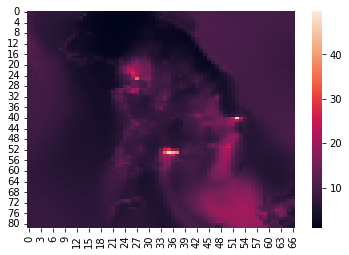

In [559]:
sns.heatmap(batch[0].numpy()[0,:,:,0][::-1])

<AxesSubplot: >

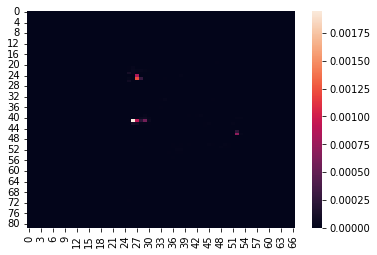

In [560]:
sns.heatmap(batch[1].numpy()[0,:,:,0][::-1])

<AxesSubplot: >

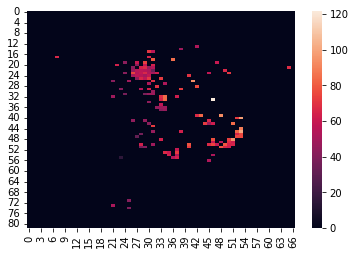

In [563]:
sns.heatmap(batch[2].numpy()[0,:,:,0])

<AxesSubplot: >

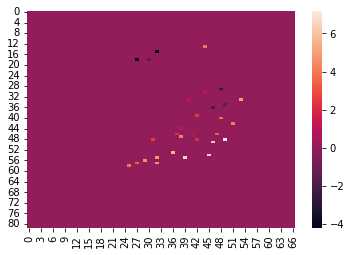

In [564]:
sns.heatmap(batch[3].numpy()[0,:,:,0])

In [565]:
batch[4]

<tf.Tensor: shape=(2, 4), dtype=uint8, numpy=
array([[13,  0,  0,  0],
       [13,  0,  0,  0]], dtype=uint8)>

In [566]:
batch[5]

<tf.Tensor: shape=(2, 4), dtype=uint8, numpy=
array([[3, 0, 0, 0],
       [3, 0, 0, 0]], dtype=uint8)>

In [567]:
batch[6]

<tf.Tensor: shape=(2, 4), dtype=uint8, numpy=
array([[23,  0,  0,  0],
       [23,  0,  0,  0]], dtype=uint8)>

In [568]:
batch[7]

<tf.Tensor: shape=(2, 4), dtype=uint8, numpy=
array([[3, 0, 0, 0],
       [4, 0, 0, 0]], dtype=uint8)>

In [ ]:
plt.figure(figsize=(100, 100))

for i in range(15):
    plt.subplot(15, 1, i+1)
    # Getting the pixel values in the [0, 1] range to plot.
    # plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.imshow(batch[3].numpy()[0,:,:,i])
    plt.axis('off')
plt.show()